# Predict Titanic Survival

The main goal is to pre-process the data as good as you can, select the right techniques and obtain a good score. The main idea behind the competition is to come
up with a model to predict whether someone survived the Titanic disaster or not based on a training set of people for whom you know whether they survived or not.

# Exploration phase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# Initialize dataframe
df = pd.read_csv('./data/train.csv')
# Show first 5 rows
df.head()
# Survived is target label, 0 = deceased and 1 = survived

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('Total rows: {}'.format(df.shape[0]))

Total rows: 891


In [4]:
print('Missing values:')
print(df.isna().sum())

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [5]:
print('Unique values per feature:')
print(df.nunique())

Unique values per feature:
PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


In [6]:
# Data cleanup (should be seperate function eventually)

# pclass, already correct 1 = 1st, 2 = 2nd, 3 = 3rd

# TODO name, people extract titles from it so we can do the same!
    # https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
    
# Sex should be turned into unique integer label, 0 or 1
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

# TODO Age in years 
    # divide each into age categories?
    # 177 missing values, perhaps we can predict the missing values with correlation

# TODO sibsp # of siblings / spouses aboard the Titanic

# TODO parch # of parents / children aboard the Titanic

# ticket (Ticket number) not sure if this is very informative? Suggestion to drop it (Pclass and fare are more informative)

# TODO fare, could be turned into fare categories

# cabin (number), 687 missing values (77%). I suggest leaving this feature out, due to its absence in training set (Pclass and fare might depict what kind of cabin better)

# embarked should be turned into unique integer label, 0 = C (Cherbourgh), 1 = Q (Queenstown), 2 = S (Southampton)
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2


In [7]:
# Print amount males and females
print(df.Sex.value_counts())
# Sex, 0 = female and 1 = male

1    577
0    314
Name: Sex, dtype: int64


Sex  Survived
0    1           233
     0            81
1    0           468
     1           109
Name: Survived, dtype: int64


<AxesSubplot:xlabel='Sex'>

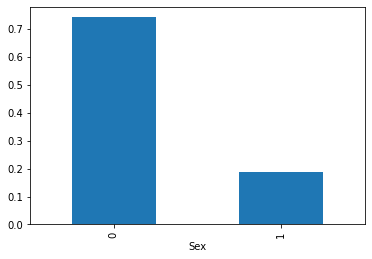

In [8]:
# Relation male/female and survived
print(df.groupby('Sex').Survived.value_counts())
df.groupby('Sex').Survived.mean().plot(kind='bar')
# Survived is target label, 0 = deceased and 1 = survived
# Sex, 0 = female and 1 = male